In [2]:
import os
os.getcwd()


'/workspace/ab-testing-simulation/notebooks'

In [6]:
df = pd.read_csv('/workspace/ab-testing-simulation/data/ab_test_data.csv')
df.head()

,user_id,group,converted,session_duration,pages_viewed,device_type,revenue
0,1,A,0,125,3,mobile,0.00
1,2,A,1,79,2,desktop,41.13
2,3,A,0,131,1,mobile,0.00
3,4,A,0,138,1,tablet,0.00
4,5,A,0,136,1,desktop,0.00


In [8]:
df.groupby('group').agg({
    'converted': ['mean', 'count'],
    'revenue': ['mean', 'sum'],
    'session_duration': ['mean', 'std']
}).round(2)

converted       revenue          session_duration       
           mean count    mean      sum             mean    std
group                                                         
A          0.12  1000    4.25  4250.10           122.46  29.67
B          0.13  1000    4.45  4446.19           134.98  31.33

In [9]:
from scipy.stats import ttest_ind

group_a = df[df['group'] == 'A']['revenue']
group_b = df[df['group'] == 'B']['revenue']

t_stat, p_val = ttest_ind(group_a, group_b, equal_var=False)
print(f'T-Statistic: {t_stat:.3f}, P-Value: {p_val:.4f}')


T-Statistic: -0.366, P-Value: 0.7146


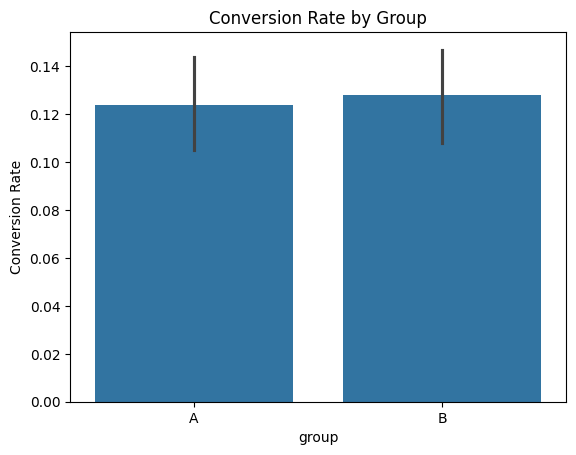

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x='group', y='converted', data=df)
plt.title('Conversion Rate by Group')
plt.ylabel('Conversion Rate')
plt.show()


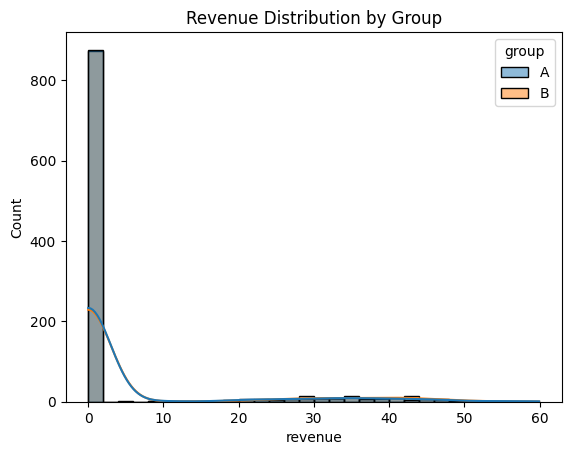

In [11]:
sns.histplot(data=df, x='revenue', hue='group', kde=True, bins=30)
plt.title('Revenue Distribution by Group')
plt.show()


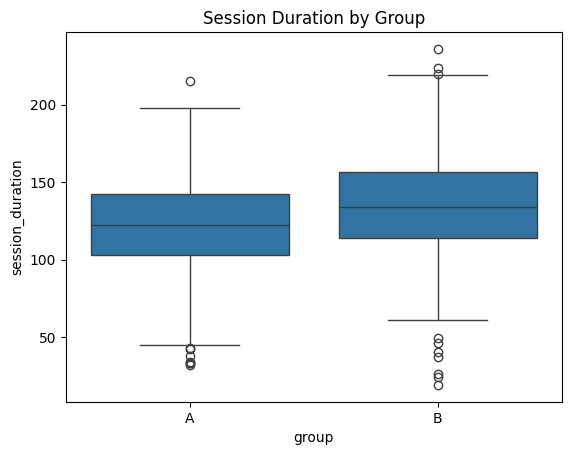

In [12]:
sns.boxplot(data=df, x='group', y='session_duration')
plt.title('Session Duration by Group')
plt.show()
